In [1]:
import json
import os
import random
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import torch
from nnsight import CONFIG, LanguageModel
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils import (
    check_pred,
    get_answer_lookback_payload_exps,
    get_answer_lookback_pointer_exps,
    get_bigtom_samples,
    get_binding_lookback_pointer_exps,
    get_prompt_token_len,
    get_ques_start_token_idx,
    get_visibility_lookback_exps,
    get_visitibility_sent_start_idx,
)

sys.path.append("../..")
from src.utils import env_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(10)

CONFIG.APP.REMOTE_LOGGING = True

os.environ["NDIF_KEY"] = env_utils.load_env_var("NDIF_KEY")
os.environ["HF_TOKEN"] = env_utils.load_env_var("HF_WRITE")

/disk/u/nikhil/.conda/envs/tomi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading model

In [2]:
is_remote = False

if is_remote:
    model = LanguageModel("meta-llama/Llama-3.1-70B")
else:
    model = LanguageModel(
        "meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        torch_dtype=torch.float16,
        dispatch=True,
    )

Loading checkpoint shards: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


# Loading Raw BigToM

In [3]:
df_false = pd.read_csv(
    os.path.join(
        env_utils.DEFAULT_DATA_DIR,
        "bigtom",
        "0_forward_belief_false_belief",
        "stories.csv",
    ),
    delimiter=";",
)

df_true = pd.read_csv(
    os.path.join(
        env_utils.DEFAULT_DATA_DIR,
        "bigtom",
        "0_forward_belief_true_belief",
        "stories.csv",
    ),
    delimiter=";",
)

# Evaluating on BigToM

## False Belief

In [3]:
samples = get_bigtom_samples(df_false, df_true, len(df_false), "false_belief")
dataloader = DataLoader(samples, batch_size=1, shuffle=False)

In [4]:
idx = 0
print(samples[idx]["prompt"], samples[idx]["answer"])

Instructions: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any belief about the container or its content which they cannot observe directly. 4. To answer the question, predict only the final state of the queried container in fewest tokens possible, strictly based on the belief of the character, mentioned in the question. 5. Do not predict the entire sentence with character or container as the final output.

Story: Noor is working as a barista at a busy coffee shop. Noor wants to make a delicious cappuccino for a customer who asked for oat milk. Noor grabs a milk pitcher and fills it with oat milk. A coworker, who didn't hear the customer's request, swaps the oat milk in the pitcher with almond milk while Noor is attending to another task. Noor does not see her coworker swapping the milk.
Question: Does Noor believe the mi

In [8]:
correct, total = 0, 0
errors = []
for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    prompt = batch["prompt"][0]
    answer = batch["answer"][0]
    prompt_len = get_prompt_token_len(model.tokenizer, prompt)

    with torch.no_grad():
        with model.generate(
            prompt,
            max_new_tokens=10,
            do_sample=False,
            num_return_sequences=1,
            pad_token_id=model.tokenizer.pad_token_id,
            eos_token_id=model.tokenizer.eos_token_id,
        ):
            out = model.generator.output.save()

    out_check = check_pred(
        model, model.tokenizer.decode(out[0][prompt_len:-1]), answer, verbose=False
    )

    if out_check == "Yes":
        correct += 1
    else:
        errors.append(
            {
                "pred": model.tokenizer.decode(out[0][prompt_len:-1]).strip(),
                "target": answer,
            }
        )
    total += 1

    del out
    torch.cuda.empty_cache()

print(f"Accuracy: {round(correct / total, 2)}")
print(f"correct: {correct} | total: {total}")

# Save errors as json
with open("results/Meta-Llama-3-70B-Instruct/model_eval/fb_errors.json", "w") as f:
    json.dump(errors, f, indent=4)

print("NOTE: NEED TO MANUALLY CHECK THE ERRORS. SOME OF THEM CAN BE CORRECT.")

  0%|          | 0/200 [00:00<?, ?it/s]/disk/u/nikhil/.conda/envs/tomi/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/nikhil/.conda/envs/tomi/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 200/200 [04:53<00:00,  1.47s/it]

Accuracy: 0.88
correct: 176 | total: 200


## True Belief

In [11]:
samples = get_bigtom_samples(df_false, df_true, len(df_true), "true_belief")
dataloader = DataLoader(samples, batch_size=1, shuffle=False)

In [12]:
idx = 0
print(samples[idx]["prompt"], samples[idx]["answer"])

Instructions: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any belief about the container or its content which they cannot observe directly. 4. To answer the question, predict only the final state of the queried container in fewest tokens possible, strictly based on the belief of the character, mentioned in the question. 5. Do not predict the entire sentence with character or container as the final output.

Story: Noor is working as a barista at a busy coffee shop. Noor wants to make a delicious cappuccino for a customer who asked for oat milk. Noor grabs a milk pitcher and fills it with oat milk. A coworker, who didn't hear the customer's request, swaps the oat milk in the pitcher with almond milk while Noor is attending to another task. Noor sees her coworker swapping the milk.
Question: Does Noor believe the milk pitch

In [14]:
correct, total = 0, 0
errors = []
for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    prompt = batch["prompt"][0]
    answer = batch["answer"][0]
    prompt_len = get_prompt_token_len(model.tokenizer, prompt)

    with torch.no_grad():
        with model.generate(
            prompt,
            max_new_tokens=10,
            do_sample=False,
            num_return_sequences=1,
            pad_token_id=model.tokenizer.pad_token_id,
            eos_token_id=model.tokenizer.eos_token_id,
        ):
            out = model.generator.output.save()

    out_check = check_pred(
        model, model.tokenizer.decode(out[0][prompt_len:-1]), answer, verbose=False
    )

    if out_check == "Yes":
        correct += 1
    else:
        errors.append(
            {
                "pred": model.tokenizer.decode(out[0][prompt_len:-1]).strip(),
                "target": answer,
            }
        )
    total += 1

    del out
    torch.cuda.empty_cache()

print(f"Accuracy: {round(correct / total, 2)}")
print(f"correct: {correct} | total: {total}")

# Save errors as json
with open("results/Meta-Llama-3-70B-Instruct/model_eval/tb_errors.json", "w") as f:
    json.dump(errors, f, indent=4)

print("NOTE: NEED TO MANUALLY CHECK THE ERRORS. SOME OF THEM CAN BE CORRECT.")

  0%|          | 0/200 [00:00<?, ?it/s]/disk/u/nikhil/.conda/envs/tomi/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/nikhil/.conda/envs/tomi/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 200/200 [04:54<00:00,  1.47s/it]

Accuracy: 0.91
correct: 182 | total: 200
NOTE: NEED TO MANUALLY CHECK THE ERRORS. SOME OF THEM CAN BE CORRECT.


# Answer Lookback

## Payload

In [4]:
n_samples = 20
batch_size = 1

dataset = get_answer_lookback_payload_exps(df_false, df_true, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [7]:
idx = 0
print(dataset[idx]["alt_prompt"], dataset[idx]["alt_ans"])
print(dataset[idx]["org_prompt"], dataset[idx]["org_ans"])
print(f"Target: {dataset[idx]['target']}")

Instructions: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any belief about the container or its content which they cannot observe directly. 4. To answer the question, predict only the final state of the queried container in fewest tokens possible, strictly based on the belief of the character, mentioned in the question. 5. Do not predict the entire sentence with character or container as the final output.

Story: Amara is a botanist exploring a dense rainforest in search of a rare orchid species. Amara's goal is to find the rare orchid and study its unique characteristics. She spots an orchid with vibrant purple petals that she thinks might be the one she is searching for. As she continues to explore, a sudden downpour washes away the purple pigment from the orchid, revealing that it is actually a common white orchid. Am

In [9]:
accs_answer_lookback_payload = {}
patch_layers = [i for i in range(0, 60, 10)] + [
    i for i in range(51, model.config.num_hidden_layers, 1)
]

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        org_prompt = batch["org_prompt"][0]
        org_ans = batch["org_ans"][0]
        alt_prompt = batch["alt_prompt"][0]
        alt_ans = batch["alt_ans"][0]
        target = batch["target"][0]

        org_prompt_len = get_prompt_token_len(model.tokenizer, org_prompt)
        alt_prompt_len = get_prompt_token_len(model.tokenizer, alt_prompt)

        with torch.no_grad():
            with model.session() as session:
                alt_layer_out = defaultdict(dict)
                with model.trace(alt_prompt):
                    alt_layer_out = (
                        model.model.layers[layer_idx].output[0][0, -1].save()
                    )

                with model.generate(
                    org_prompt,
                    max_new_tokens=2,
                    do_sample=False,
                    num_return_sequences=1,
                    pad_token_id=model.tokenizer.pad_token_id,
                    eos_token_id=model.tokenizer.eos_token_id,
                ):
                    model.model.layers[layer_idx].output[0][0, -1] = alt_layer_out

                    out = model.generator.output.save()

                del alt_layer_out
                torch.cuda.empty_cache()

            pred = model.tokenizer.decode(out[0][org_prompt_len:-1]).strip()
            # print(f"Prediction: {pred} | Target: {target}")
            if pred in target:
                correct += 1
            total += 1

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_answer_lookback_payload[layer_idx] = acc

100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 0 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 10 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 20 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 30 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 40 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 50 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 51 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 52 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 53 | Accuracy: 0.25


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 54 | Accuracy: 0.3


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 55 | Accuracy: 0.35


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 56 | Accuracy: 0.75


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 57 | Accuracy: 0.8


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 58 | Accuracy: 0.8


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 59 | Accuracy: 0.8


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 60 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 61 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 62 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 63 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 64 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 65 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 66 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 67 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 68 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 69 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 70 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 71 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 72 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 73 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 74 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 75 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 76 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Layer: 77 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Layer: 78 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

Layer: 79 | Accuracy: 0.9


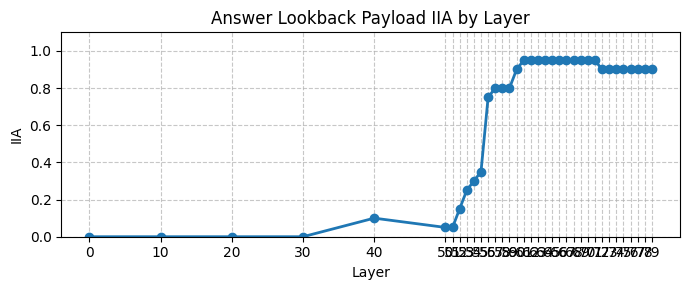

In [13]:
# Visualize accs_answer_lookback_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_answer_lookback_payload.keys())
accuracies = list(accs_answer_lookback_payload.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Answer Lookback Payload IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Pointer

In [4]:
n_samples = 20
batch_size = 1

dataset = get_answer_lookback_pointer_exps(df_false, df_true, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
idx = 0
print(dataset[idx]["alt_prompt"], dataset[idx]["alt_ans"])
print(dataset[idx]["org_prompt"], dataset[idx]["org_ans"])
print(f"Target: {dataset[idx]['target']}")

Instructions: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any belief about the container or its content which they cannot observe directly. 4. To answer the question, predict only the final state of the queried container in fewest tokens possible, strictly based on the belief of the character, mentioned in the question. 5. Do not predict the entire sentence with character or container as the final output.

Story: Amara is a botanist exploring a dense rainforest in search of a rare orchid species. Amara's goal is to find the rare orchid and study its unique characteristics. She spots an orchid with vibrant purple petals that she thinks might be the one she is searching for. As she continues to explore, a sudden downpour washes away the purple pigment from the orchid, revealing that it is actually a common white orchid. Am

In [9]:
accs_answer_lookback_pointer = {}
patch_layers = [i for i in range(20, 70, 2)] + [
    i for i in range(70, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        org_prompt = batch["org_prompt"][0]
        org_ans = batch["org_ans"][0]
        alt_prompt = batch["alt_prompt"][0]
        alt_ans = batch["alt_ans"][0]
        target = batch["target"][0]

        org_prompt_len = get_prompt_token_len(model.tokenizer, org_prompt)
        alt_prompt_len = get_prompt_token_len(model.tokenizer, alt_prompt)

        with torch.no_grad():
            with model.session() as session:
                alt_layer_out = defaultdict(dict)
                with model.trace(alt_prompt):
                    alt_layer_out = (
                        model.model.layers[layer_idx].output[0][0, -1].save()
                    )

                with model.generate(
                    org_prompt,
                    max_new_tokens=2,
                    do_sample=False,
                    num_return_sequences=1,
                    pad_token_id=model.tokenizer.pad_token_id,
                    eos_token_id=model.tokenizer.eos_token_id,
                ):
                    model.model.layers[layer_idx].output[0][0, -1] = alt_layer_out

                    out = model.generator.output.save()

                del alt_layer_out
                torch.cuda.empty_cache()

            pred = model.tokenizer.decode(out[0][org_prompt_len:-1]).strip()
            # print(f"Pred: {pred} | Target: {target}")
            if pred in target:
                correct += 1
            total += 1

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_answer_lookback_pointer[layer_idx] = acc

100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 20 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 22 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 24 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 26 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 28 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 30 | Accuracy: 0.3


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 32 | Accuracy: 0.8


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 34 | Accuracy: 0.85


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 36 | Accuracy: 0.85


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 38 | Accuracy: 0.8


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 40 | Accuracy: 0.75


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 42 | Accuracy: 0.75


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 44 | Accuracy: 0.75


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 46 | Accuracy: 0.75


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 48 | Accuracy: 0.75


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 50 | Accuracy: 0.75


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 52 | Accuracy: 0.6


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 54 | Accuracy: 0.25


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 56 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 58 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 60 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 62 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 64 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 66 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 68 | Accuracy: 0.0


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

Layer: 70 | Accuracy: 0.0


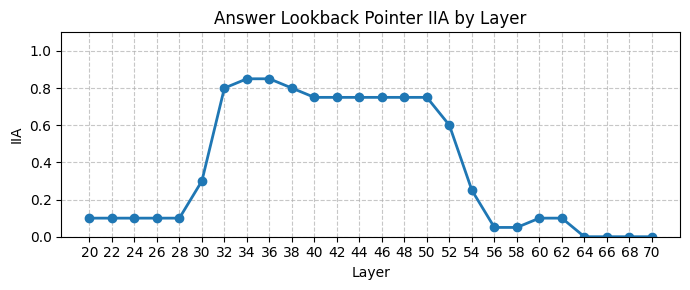

In [10]:
# Visualize accs_answer_lookback_pointer as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_answer_lookback_pointer.keys())
accuracies = list(accs_answer_lookback_pointer.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Answer Lookback Pointer IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Binding Lookback

## Pointer

In [6]:
n_samples = 20
batch_size = 1

dataset = get_binding_lookback_pointer_exps(df_false, df_true, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [7]:
idx = 0
print(dataset[idx]["alt_prompt"], dataset[idx]["alt_ans"])
print(dataset[idx]["org_prompt"], dataset[idx]["org_ans"])
print(f"Target: {dataset[idx]['target']}")

Instructions: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any belief about the container or its content which they cannot observe directly. 4. To answer the question, predict only the final state of the queried container in fewest tokens possible, strictly based on the belief of the character, mentioned in the question. 5. Do not predict the entire sentence with character or container as the final output.

Story: Noor is working as a barista at a busy coffee shop. Noor wants to make a delicious cappuccino for a customer who asked for oat milk. Noor grabs a milk pitcher and fills it with oat milk. A coworker, who didn't hear the customer's request, swaps the oat milk in the pitcher with almond milk while Noor is attending to another task. Noor sees her coworker swapping the milk.
Question: Does Noor believe the milk pitch

In [9]:
accs_binding_lookback_pointer = {}
patch_layers = [i for i in range(0, 40, 2)] + [
    i for i in range(40, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        org_prompt = batch["org_prompt"][0]
        org_ans = batch["org_ans"][0]
        alt_prompt = batch["alt_prompt"][0]
        alt_ans = batch["alt_ans"][0]
        target = batch["target"][0]

        org_prompt_len = get_prompt_token_len(model.tokenizer, org_prompt)
        alt_prompt_len = get_prompt_token_len(model.tokenizer, alt_prompt)
        org_ques_start_idx = get_ques_start_token_idx(model.tokenizer, org_prompt)
        alt_ques_start_idx = get_ques_start_token_idx(model.tokenizer, alt_prompt)

        with torch.no_grad():
            with model.session() as session:
                alt_layer_out = defaultdict(dict)
                with model.trace(alt_prompt):
                    for t_idx, t in enumerate(
                        [
                            i
                            for i in range(
                                alt_ques_start_idx + 3, alt_ques_start_idx + 5
                            )
                        ]
                    ):
                        alt_layer_out[t_idx] = (
                            model.model.layers[layer_idx].output[0][0, t].save()
                        )

                with model.generate(
                    org_prompt,
                    max_new_tokens=2,
                    do_sample=False,
                    num_return_sequences=1,
                    pad_token_id=model.tokenizer.pad_token_id,
                    eos_token_id=model.tokenizer.eos_token_id,
                ):
                    for t_idx, t in enumerate(
                        [
                            i
                            for i in range(
                                org_ques_start_idx + 3, org_ques_start_idx + 5
                            )
                        ]
                    ):
                        model.model.layers[layer_idx].output[0][0, t] = alt_layer_out[
                            t_idx
                        ]

                    out = model.generator.output.save()

                del alt_layer_out
                torch.cuda.empty_cache()

            pred = model.tokenizer.decode(out[0][org_prompt_len:-1]).strip()
            # print(f"Pred: {pred} | Target: {target}")
            if pred in target:
                correct += 1
            total += 1

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_binding_lookback_pointer[layer_idx] = acc

100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 0 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 2 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 4 | Accuracy: 0.2


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 6 | Accuracy: 0.6


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 8 | Accuracy: 0.8


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 10 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 12 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 14 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 16 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 18 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 20 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 22 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 24 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 26 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 28 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 30 | Accuracy: 0.45


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 32 | Accuracy: 0.1


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 34 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 36 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 38 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 40 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 50 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Layer: 60 | Accuracy: 0.05


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

Layer: 70 | Accuracy: 0.05


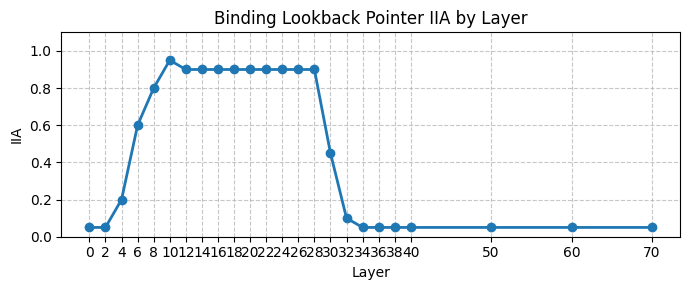

In [10]:
# Visualize accs_binding_lookback_pointer as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_binding_lookback_pointer.keys())
accuracies = list(accs_binding_lookback_pointer.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Binding Lookback Pointer IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Visibility Lookback

In [6]:
n_samples = 20
batch_size = 1

dataset = get_visibility_lookback_exps(df_false, df_true, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [7]:
idx = 0
print(dataset[idx]["alt_prompt"], dataset[idx]["alt_ans"])
print(dataset[idx]["org_prompt"], dataset[idx]["org_ans"])
print(f"Target: {dataset[idx]['target']}")

Instructions: 1. Track the belief of each character as described in the story. 2. A character's belief is formed only when they perform an action themselves or can observe the action taking place. 3. A character does not have any belief about the container or its content which they cannot observe directly. 4. To answer the question, predict only the final state of the queried container in fewest tokens possible, strictly based on the belief of the character, mentioned in the question. 5. Do not predict the entire sentence with character or container as the final output.

Story: Noor is working as a barista at a busy coffee shop. Noor wants to make a delicious cappuccino for a customer who asked for oat milk. Noor grabs a milk pitcher and fills it with oat milk. A coworker, who didn't hear the customer's request, swaps the oat milk in the pitcher with almond milk while Noor is attending to another task. Noor sees her coworker swapping the milk.
Question: Does Noor believe the milk pitch

## Source

In [9]:
accs_visibility_lookback_source = {}
patch_layers = [i for i in range(0, 41, 2)] + [
    i for i in range(50, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        org_prompt = batch["org_prompt"][0]
        org_ans = batch["org_ans"][0]
        alt_prompt = batch["alt_prompt"][0]
        alt_ans = batch["alt_ans"][0]
        target = batch["target"][0]

        org_prompt_len = get_prompt_token_len(model.tokenizer, org_prompt)
        alt_prompt_len = get_prompt_token_len(model.tokenizer, alt_prompt)
        org_ques_start_idx = get_ques_start_token_idx(model.tokenizer, org_prompt)
        alt_ques_start_idx = get_ques_start_token_idx(model.tokenizer, alt_prompt)
        org_vis_sent_start_idx = get_visitibility_sent_start_idx(
            model.tokenizer, org_prompt
        )
        alt_vis_sent_start_idx = get_visitibility_sent_start_idx(
            model.tokenizer, alt_prompt
        )

        with torch.no_grad():
            with model.session() as session:
                alt_layer_out = defaultdict(dict)
                with model.trace(alt_prompt):
                    for t_idx, t in enumerate(
                        [i for i in range(alt_vis_sent_start_idx, alt_ques_start_idx)]
                    ):
                        alt_layer_out[t_idx] = (
                            model.model.layers[layer_idx].output[0][0, t].save()
                        )

                with model.generate(
                    org_prompt,
                    max_new_tokens=2,
                    do_sample=False,
                    num_return_sequences=1,
                    pad_token_id=model.tokenizer.pad_token_id,
                    eos_token_id=model.tokenizer.eos_token_id,
                ):
                    for t_idx, t in enumerate(
                        [
                            i
                            for i in range(
                                org_vis_sent_start_idx,
                                org_vis_sent_start_idx + len(alt_layer_out),
                            )
                        ]
                    ):
                        model.model.layers[layer_idx].output[0][0, t] = alt_layer_out[
                            t_idx
                        ]

                    out = model.generator.output.save()

                del alt_layer_out
                torch.cuda.empty_cache()

            pred = model.tokenizer.decode(out[0][org_prompt_len:-1]).strip()
            # print(f"Pred: {pred} | Target: {target}")
            if pred in target:
                correct += 1
            total += 1

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_visibility_lookback_source[layer_idx] = acc

100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 0 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 2 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 4 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 6 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 8 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 10 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 12 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 14 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 16 | Accuracy: 0.9


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 18 | Accuracy: 0.55


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 20 | Accuracy: 0.6


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 22 | Accuracy: 0.5


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Layer: 24 | Accuracy: 0.45


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 26 | Accuracy: 0.2


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 28 | Accuracy: 0.2


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 30 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 32 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 34 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 36 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 38 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 40 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 50 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Layer: 60 | Accuracy: 0.15


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]

Layer: 70 | Accuracy: 0.15


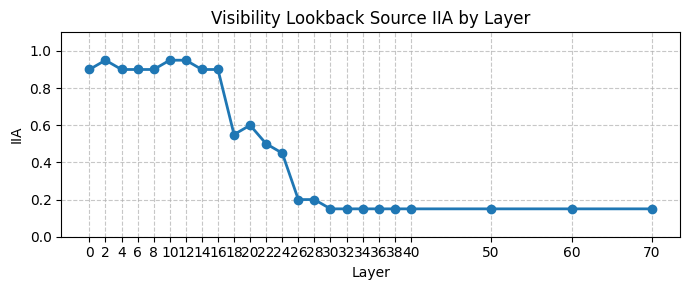

In [10]:
# Visualize accs_visibility_lookback_source as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_visibility_lookback_source.keys())
accuracies = list(accs_visibility_lookback_source.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Visibility Lookback Source IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Payload

In [12]:
accs_visibility_lookback_payload = {}
patch_layers = [i for i in range(20, 70, 2)] + [
    i for i in range(70, model.config.num_hidden_layers, 10)
]

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        org_prompt = batch["org_prompt"][0]
        org_ans = batch["org_ans"][0]
        alt_prompt = batch["alt_prompt"][0]
        alt_ans = batch["alt_ans"][0]
        target = batch["target"][0]

        org_prompt_len = get_prompt_token_len(model.tokenizer, org_prompt)
        alt_prompt_len = get_prompt_token_len(model.tokenizer, alt_prompt)
        org_ques_start_idx = get_ques_start_token_idx(model.tokenizer, org_prompt)
        alt_ques_start_idx = get_ques_start_token_idx(model.tokenizer, alt_prompt)
        org_vis_sent_start_idx = get_visitibility_sent_start_idx(
            model.tokenizer, org_prompt
        )
        alt_vis_sent_start_idx = get_visitibility_sent_start_idx(
            model.tokenizer, alt_prompt
        )

        with torch.no_grad():
            with model.session() as session:
                alt_layer_out = defaultdict(dict)
                with model.trace(alt_prompt):
                    for t_idx, t in enumerate(
                        [i for i in range(alt_ques_start_idx, alt_prompt_len)]
                    ):
                        alt_layer_out[t_idx] = (
                            model.model.layers[layer_idx].output[0][0, t].save()
                        )

                with model.generate(
                    org_prompt,
                    max_new_tokens=2,
                    do_sample=False,
                    num_return_sequences=1,
                    pad_token_id=model.tokenizer.pad_token_id,
                    eos_token_id=model.tokenizer.eos_token_id,
                ):
                    for t_idx, t in enumerate(
                        [i for i in range(org_ques_start_idx, org_prompt_len)]
                    ):
                        model.model.layers[layer_idx].output[0][0, t] = alt_layer_out[
                            t_idx
                        ]

                    out = model.generator.output.save()

                del alt_layer_out
                torch.cuda.empty_cache()

            pred = model.tokenizer.decode(out[0][org_prompt_len:-1]).strip()
            # print(f"Pred: {pred} | Target: {target}")
            if pred in target:
                correct += 1
            total += 1

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_visibility_lookback_payload[layer_idx] = acc

  0%|          | 0/20 [00:00<?, ?it/s]/disk/u/nikhil/.conda/envs/tomi/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/nikhil/.conda/envs/tomi/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 20 | Accuracy: 0.15


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 22 | Accuracy: 0.2


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 24 | Accuracy: 0.2


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 26 | Accuracy: 0.7


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 28 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 30 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 32 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 34 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 36 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 38 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 40 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 42 | Accuracy: 0.9


100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Layer: 44 | Accuracy: 0.9


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Layer: 46 | Accuracy: 0.9


100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


Layer: 48 | Accuracy: 0.9


100%|██████████| 20/20 [00:47<00:00,  2.35s/it]


Layer: 50 | Accuracy: 0.9


100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


Layer: 52 | Accuracy: 0.9


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


Layer: 54 | Accuracy: 0.9


100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Layer: 56 | Accuracy: 0.95


100%|██████████| 20/20 [00:43<00:00,  2.20s/it]


Layer: 58 | Accuracy: 0.95


100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Layer: 60 | Accuracy: 0.9


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


Layer: 62 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 64 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 66 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Layer: 68 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]

Layer: 70 | Accuracy: 0.95


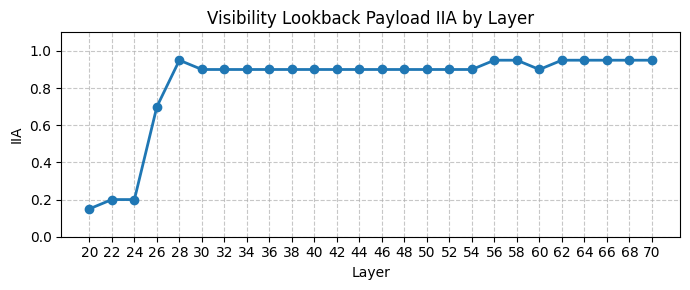

In [13]:
# Visualize accs_visibility_lookback_payload as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_visibility_lookback_payload.keys())
accuracies = list(accs_visibility_lookback_payload.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Visibility Lookback Payload IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

## Address and Pointer

In [15]:
accs_visibility_address_pointer = {}
patch_layers = [i for i in range(0, model.config.num_hidden_layers, 4)]

for layer_idx in patch_layers:
    correct, total = 0, 0

    for bi, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        org_prompt = batch["org_prompt"][0]
        org_ans = batch["org_ans"][0]
        alt_prompt = batch["alt_prompt"][0]
        alt_ans = batch["alt_ans"][0]
        target = batch["target"][0]

        org_prompt_len = get_prompt_token_len(model.tokenizer, org_prompt)
        alt_prompt_len = get_prompt_token_len(model.tokenizer, alt_prompt)
        org_ques_start_idx = get_ques_start_token_idx(model.tokenizer, org_prompt)
        alt_ques_start_idx = get_ques_start_token_idx(model.tokenizer, alt_prompt)
        org_vis_sent_start_idx = get_visitibility_sent_start_idx(
            model.tokenizer, org_prompt
        )
        alt_vis_sent_start_idx = get_visitibility_sent_start_idx(
            model.tokenizer, alt_prompt
        )

        with torch.no_grad():
            with model.session() as session:
                alt_vis_layer_out, alt_quert_layer_out = (
                    defaultdict(dict),
                    defaultdict(dict),
                )
                with model.trace(alt_prompt):
                    for t_idx, t in enumerate(
                        [i for i in range(alt_vis_sent_start_idx, alt_ques_start_idx)]
                    ):
                        alt_vis_layer_out[t_idx] = (
                            model.model.layers[layer_idx].output[0][0, t].save()
                        )

                    for t_idx, t in enumerate(
                        [i for i in range(alt_ques_start_idx, alt_prompt_len)]
                    ):
                        alt_quert_layer_out[t_idx] = (
                            model.model.layers[layer_idx].output[0][0, t].save()
                        )

                with model.generate(
                    org_prompt,
                    max_new_tokens=2,
                    do_sample=False,
                    num_return_sequences=1,
                    pad_token_id=model.tokenizer.pad_token_id,
                    eos_token_id=model.tokenizer.eos_token_id,
                ):
                    for t_idx, t in enumerate(
                        [
                            i
                            for i in range(
                                org_vis_sent_start_idx,
                                org_vis_sent_start_idx + len(alt_vis_layer_out),
                            )
                        ]
                    ):
                        model.model.layers[layer_idx].output[0][0, t] = (
                            alt_vis_layer_out[t_idx]
                        )

                    for t_idx, t in enumerate(
                        [i for i in range(org_ques_start_idx, org_prompt_len)]
                    ):
                        model.model.layers[layer_idx].output[0][0, t] = (
                            alt_quert_layer_out[t_idx]
                        )

                    out = model.generator.output.save()

                del alt_vis_layer_out
                torch.cuda.empty_cache()

            pred = model.tokenizer.decode(out[0][org_prompt_len:-1]).strip()
            # print(f"Pred: {pred} | Target: {target}")
            if pred in target:
                correct += 1
            total += 1

    acc = round(correct / total, 2)
    print(f"Layer: {layer_idx} | Accuracy: {acc}")

    accs_visibility_address_pointer[layer_idx] = acc

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 0 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 4 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 8 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 12 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 16 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 20 | Accuracy: 0.8


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 24 | Accuracy: 0.9


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Layer: 28 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 32 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 36 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 40 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 44 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Layer: 48 | Accuracy: 0.95


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Layer: 52 | Accuracy: 0.95


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Layer: 56 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Layer: 60 | Accuracy: 0.95


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Layer: 64 | Accuracy: 0.95


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Layer: 68 | Accuracy: 0.95


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Layer: 72 | Accuracy: 0.95


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]

Layer: 76 | Accuracy: 0.95


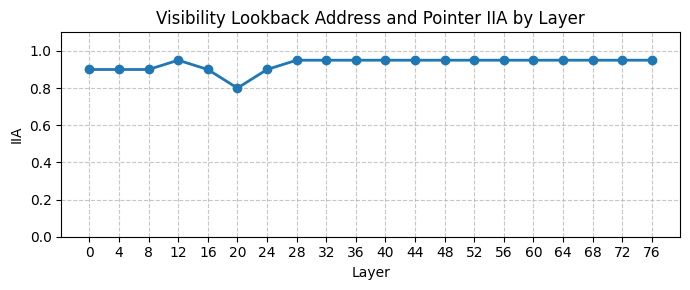

In [16]:
# Visualize accs_visibility_address_pointer as a line plot
plt.figure(figsize=(7, 3))
layers = list(accs_visibility_address_pointer.keys())
accuracies = list(accs_visibility_address_pointer.values())

plt.plot(layers, accuracies, marker="o", linestyle="-", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("IIA")
plt.title("Visibility Lookback Address and Pointer IIA by Layer")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(layers)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()